# DNN on Cluster 
Notebook to perform some model on a single Cluster.<br>
Data read are from table SLIDING_WINDOWS_DATASET that contains a sliding windows of:
- feats about last 7-days meteo values
- pollen value for the next day

Cluster associations are read from a local file: we have different cluster annotations made by different techniques.<br>
Starting from past data, we can apply an <b>Attention-based DNN Model</b> to forecast the next week or day.

<h3>Import</h3>

In [65]:
from tqdm.auto import tqdm
import json
import math
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from google.cloud import bigquery

import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode, iplot

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

my_cmap = plt.get_cmap("Paired")
init_notebook_mode(connected=True)  
tqdm.pandas()

<h3>Config</h3>

In [66]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
BQ_DATASET = 'SAMPLE_DATA'
JOINED_BQ_DATASET = 'JOINED_DATA'

# Const
COMMON_PERIOD_INIT = '2011-01-01'
COMMON_PERIOD_END = '2021-12-31' 

# Cols
DATE_COL = 'date'

# Feats
METEO_FEATS = ['week_amax', 
               'station_lat_amax', 'station_lon_amax', 'station_H_piano_strada_amax', 'station_H_mslm_amax', 
               'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum', 
               'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
               'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum',                                               
               'PREC_amin', 'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis']
POLLEN_FEATS = ['pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median', 'pol_value_amax', 
                'pol_value_skew', 'pol_value_kurtosis',
                'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3',
                'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6',
                'pol_value_prev_7']
ORIGINAL_FEATS = METEO_FEATS + POLLEN_FEATS
LABEL_COL = 'pol_value_label'

# Params
BATCH_SIZE = 512 #128
SEQUENCE_LEN = 7
K_INTERVAL = 5

# Layout
COLOR_PALETTE = px.colors.qualitative.Prism

OUTPUT_CLUSTER_FILENAME = "../../data/clustering_intervals.csv" 


<h3>Methods</h3>

In [67]:
# Read Methods

def _run_query(client, query): 
    df = client.query(query).to_dataframe()
    return df

def _read_table(client, project_id, dataset, table):
    query = "SELECT * FROM `{}.{}.{}` ".format(project_id, dataset, table)
    df = _run_query(client, query)
    return df

def _read_table_delta(client, project_id, dataset, table, date_col, init, end):
    query = "SELECT * FROM `{}.{}.{}` WHERE {} > '{}' AND {} < '{}' ".format(project_id, dataset, table, date_col, init, date_col, end)
    df = _run_query(client, query)
    if 'reftime' in df.columns:
        df.sort_values(by='reftime', inplace=True)
    elif date_col in df.columns:
        df.sort_values(by=date_col, inplace=True)
    else:
        return None
    return df


In [68]:
# Process Methods

def _shift_week(x, week):
    date = x - timedelta(days=7*week)
    return date.strftime("%Y-%m-%d")

def _normalize(x, range_dict, index_col, label_col):
    pol_min = range_dict[x[index_col]]['min']
    pol_max = range_dict[x[index_col]]['max']
    return (x[label_col] - pol_min) / (pol_max - pol_min)

def _set_range_value(x, range_dict, index_col, col, k): 
    pol_min = range_dict[x[index_col]]['min']
    pol_max = range_dict[x[index_col]]['max']
    intervals = np.linspace(pol_min, pol_max, k)
    for i, interval in enumerate(intervals):
        if x[col] <= interval:
            return np.float32(i)
    return None

In [69]:
# Widget Methods

def _create_scaling_widget():
    wdgt = widgets.Dropdown(options=['interval', 'min-max-linear'], 
                            description='Select Feats:', layout={"width":"50%"})
    return wdgt

def _create_cluster_widget(clusters):
    cluster_wdgt = widgets.Dropdown(options=clusters, description='Cluster id:', layout={"width":"50%"})
    return cluster_wdgt

<h3>1. Config</h3>

<h4>1.1 Config BigQuery</h4>

In [70]:
# Setup Client

bq_client = bigquery.Client(project=PROJECT_ID)
bq_client

<h3>2. Read Data</h3>

<h4>2.1 Read Cluster file</h4>

In [71]:
clusters_df = pd.read_csv(OUTPUT_CLUSTER_FILENAME)
print(clusters_df.shape)
clusters_df.head(3)

(363, 3)


,station_id,pol_var_id,cluster
0,1,B48001,3
1,1,B48002,2
2,1,B48003,1


<h4>2.2 Read Tables</h4>

<b>SLIDING_WINDOWS_DATASET</b> joins meteo features of last 7-days with the next-day pollen value.

In [72]:
# Read ALL_METEO_FEATS_POL_DAT

sliding_windows_dataset_df = _read_table_delta(bq_client, PROJECT_ID, JOINED_BQ_DATASET, 
                                               "SLIDING_WINDOWS_DATASET", "date",
                                               COMMON_PERIOD_INIT, COMMON_PERIOD_END)
sliding_windows_dataset_df['date'] = sliding_windows_dataset_df['date'].astype("str")
print(sliding_windows_dataset_df.shape)
sliding_windows_dataset_df.head(3)

(783015, 55)


,date,station_id,pol_var_id,date_diff,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,...,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label,season_label,trend_label,residual_label
463994,2011-01-02 00:00:00+00:00,8,B48029,9,0.0,11.4,0.015630,0.144917,18.6,-13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.338131,0.829370,0.508761
513242,2011-01-02 00:00:00+00:00,10,B48016,7,0.0,12.8,0.014118,0.146686,16.8,-12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.770304,3.846548,-1.076244
440463,2011-01-02 00:00:00+00:00,7,B48034,8,0.0,13.0,0.014454,0.153349,17.2,-15.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.641494,6.968164,-2.326670


<h3>3. Prepare Data</h3>

<h4>3.1 Prepare Data</h4>

In [73]:
# Set data

data_df = sliding_windows_dataset_df.copy()

In [74]:
# Select a single cluster 

clusters = sorted(clusters_df.cluster.unique())
cluster_wdgt = _create_cluster_widget(clusters)
display(cluster_wdgt)

Dropdown(description='Cluster id:', layout=Layout(width='50%'), options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), value=…

In [75]:
# Filter data for station, bcode in the selected cluster

filt_clusters_df = clusters_df[clusters_df['cluster']==cluster_wdgt.value][['station_id', 'pol_var_id']]
data_df = pd.merge(data_df, filt_clusters_df, how='right', on=['station_id', 'pol_var_id'])
print(data_df.shape)
data_df.head(3)

(58663, 55)


,date,station_id,pol_var_id,date_diff,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,...,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label,season_label,trend_label,residual_label
0,2011-03-07 00:00:00+00:00,1,B48018,7,0.0,22.4,0.163866,0.793851,195.0,-9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227010,1.504411,-1.731421
1,2011-03-08 00:00:00+00:00,1,B48018,7,0.0,14.0,0.111261,0.453520,132.4,-13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.334604,1.505589,-1.840193
2,2011-03-09 00:00:00+00:00,1,B48018,7,0.0,14.0,0.059832,0.321228,71.2,-13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170328,1.505589,-1.675917


<h4>3.2 Create Dataset</h4>

In [76]:
# Create dataset

data_df.sort_values(['station_id', 'pol_var_id', DATE_COL], inplace=True)
dataset_df = data_df[['station_id', 'pol_var_id', DATE_COL]  + ORIGINAL_FEATS + [LABEL_COL]]
print(dataset_df.shape)
dataset_df.head(3)

(58663, 45)


,station_id,pol_var_id,date,week_amax,station_lat_amax,station_lon_amax,station_H_piano_strada_amax,station_H_mslm_amax,B13011_min_amin,B13011_max_amax,...,pol_value_skew,pol_value_kurtosis,pol_value_prev_1,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label
0,1,B48018,2011-03-07 00:00:00+00:00,10.0,44.4914,11.3694,80.0,101.0,0.0,22.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,B48018,2011-03-08 00:00:00+00:00,10.0,44.4914,11.3694,80.0,101.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,B48018,2011-03-09 00:00:00+00:00,10.0,44.4914,11.3694,80.0,101.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
# Set index and drop nan

dataset_df.set_index(DATE_COL, inplace=True)
dataset_df.dropna(inplace=True)
print(dataset_df.shape)
dataset_df.head(3)

(58663, 44)


,station_id,pol_var_id,week_amax,station_lat_amax,station_lon_amax,station_H_piano_strada_amax,station_H_mslm_amax,B13011_min_amin,B13011_max_amax,B13011_mean_mean,...,pol_value_skew,pol_value_kurtosis,pol_value_prev_1,pol_value_prev_2,pol_value_prev_3,pol_value_prev_4,pol_value_prev_5,pol_value_prev_6,pol_value_prev_7,pol_value_label
date,,,,,,,,,,,,,,,,,,,,,
2011-03-07 00:00:00+00:00,1,B48018,10.0,44.4914,11.3694,80.0,101.0,0.0,22.4,0.163866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-08 00:00:00+00:00,1,B48018,10.0,44.4914,11.3694,80.0,101.0,0.0,14.0,0.111261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-09 00:00:00+00:00,1,B48018,10.0,44.4914,11.3694,80.0,101.0,0.0,14.0,0.059832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<h3>4. Preprocess Data</h3>

<h4>4.1 Add station & bcode 1-hot encoding features</h4>

In [78]:
# Add 1-hot encoding

# extract 1-hot encoding
stations_one_hot_encoded = pd.get_dummies(dataset_df['station_id'], prefix='station_id')
pollen_one_hot_encoded = pd.get_dummies(dataset_df['pol_var_id'], prefix='pol_var_id')

# add to df
dataset_df = pd.concat([dataset_df, stations_one_hot_encoded], axis=1)
dataset_df = pd.concat([dataset_df, pollen_one_hot_encoded], axis=1)
print(dataset_df.shape)
dataset_df.head(3)

(58663, 61)


,station_id,pol_var_id,week_amax,station_lat_amax,station_lon_amax,station_H_piano_strada_amax,station_H_mslm_amax,B13011_min_amin,B13011_max_amax,B13011_mean_mean,...,station_id_9,station_id_10,station_id_11,station_id_13,pol_var_id_B48007,pol_var_id_B48011,pol_var_id_B48018,pol_var_id_B48023,pol_var_id_B48025,pol_var_id_B48041
date,,,,,,,,,,,,,,,,,,,,,
2011-03-07 00:00:00+00:00,1,B48018,10.0,44.4914,11.3694,80.0,101.0,0.0,22.4,0.163866,...,0,0,0,0,0,0,1,0,0,0
2011-03-08 00:00:00+00:00,1,B48018,10.0,44.4914,11.3694,80.0,101.0,0.0,14.0,0.111261,...,0,0,0,0,0,0,1,0,0,0
2011-03-09 00:00:00+00:00,1,B48018,10.0,44.4914,11.3694,80.0,101.0,0.0,14.0,0.059832,...,0,0,0,0,0,0,1,0,0,0


In [79]:
# ADD to Features

FEATS = ORIGINAL_FEATS + stations_one_hot_encoded.columns.values.tolist() + pollen_one_hot_encoded.columns.values.tolist()
#FEATS = ORIGINAL_FEATS
N_FEATS = len(FEATS)#+1
N_FEATS


58

<h4>4.2 Normalize Meteo Features (on columns)</h4>

In [80]:
# Normalize all cols except for pollen ones; Save max cols: multiply predicted values to get not-normalized values

cols_max = []
for col in METEO_FEATS:
    scaler = MinMaxScaler()
    dataset_df[col] = pd.DataFrame(scaler.fit_transform(dataset_df[[col]])).values
    cols_max.append(int(scaler.data_max_))
print("Max cols:", cols_max)
print(dataset_df.shape)
dataset_df.head(3)

Max cols: [53, 45, 12, 94, 115, 0, 116, 0, 3, 933, -2, 1084, 356, 372, 60514, 22, 41, 29, 14, 417, 10, 55, 81, 38, 219, 2, 2]
(58663, 61)


,station_id,pol_var_id,week_amax,station_lat_amax,station_lon_amax,station_H_piano_strada_amax,station_H_mslm_amax,B13011_min_amin,B13011_max_amax,B13011_mean_mean,...,station_id_9,station_id_10,station_id_11,station_id_13,pol_var_id_B48007,pol_var_id_B48011,pol_var_id_B48018,pol_var_id_B48023,pol_var_id_B48025,pol_var_id_B48041
date,,,,,,,,,,,,,,,,,,,,,
2011-03-07 00:00:00+00:00,1,B48018,0.022727,0.440889,0.580657,0.847826,0.847826,0.0,0.192440,0.208824,...,0,0,0,0,0,0,1,0,0,0
2011-03-08 00:00:00+00:00,1,B48018,0.022727,0.440889,0.580657,0.847826,0.847826,0.0,0.120275,0.141786,...,0,0,0,0,0,0,1,0,0,0
2011-03-09 00:00:00+00:00,1,B48018,0.022727,0.440889,0.580657,0.847826,0.847826,0.0,0.120275,0.076248,...,0,0,0,0,0,0,1,0,0,0


<h4>4.3 Normalize Pollen Features & Label (aggregating by pol_var_id)</h4>

Dataset contains the previous pollen value as feature and the next pollen value as label.<br>
We can normalize with a min-max-scaler or in a range interval.

In [81]:
# Create a 5-values interval for pollen values

for col in tqdm(POLLEN_FEATS):
    range_df = dataset_df[['pol_var_id', col]].groupby('pol_var_id').agg(['min', 'max'])
    ranges = {}
    for index, values in zip(range_df.index, range_df.values):
        ranges[index] = {'min': values[0], 'max': values[1]}        
    dataset_df[col] = dataset_df.apply(lambda x: _set_range_value(x, ranges, 'pol_var_id', col, K_INTERVAL), 
                                       axis=1)
dataset_df[LABEL_COL] = dataset_df.apply(lambda x: _set_range_value(x, ranges, 'pol_var_id', LABEL_COL, 
                                                                K_INTERVAL), axis=1)

  0%|          | 0/14 [00:00<?, ?it/s]

<h4>4.4 Sort Data</h4>

In [82]:
# Set index to datetime

dataset_df.index = pd.to_datetime(dataset_df.index)

In [83]:
# Sort

dataset_df.sort_values(by=['station_id', 'pol_var_id', 'date'], inplace=True)
print(dataset_df.shape)
dataset_df.head(3)

(58663, 61)


,station_id,pol_var_id,week_amax,station_lat_amax,station_lon_amax,station_H_piano_strada_amax,station_H_mslm_amax,B13011_min_amin,B13011_max_amax,B13011_mean_mean,...,station_id_9,station_id_10,station_id_11,station_id_13,pol_var_id_B48007,pol_var_id_B48011,pol_var_id_B48018,pol_var_id_B48023,pol_var_id_B48025,pol_var_id_B48041
date,,,,,,,,,,,,,,,,,,,,,
2011-03-07 00:00:00+00:00,1,B48018,0.022727,0.440889,0.580657,0.847826,0.847826,0.0,0.192440,0.208824,...,0,0,0,0,0,0,1,0,0,0
2011-03-08 00:00:00+00:00,1,B48018,0.022727,0.440889,0.580657,0.847826,0.847826,0.0,0.120275,0.141786,...,0,0,0,0,0,0,1,0,0,0
2011-03-09 00:00:00+00:00,1,B48018,0.022727,0.440889,0.580657,0.847826,0.847826,0.0,0.120275,0.076248,...,0,0,0,0,0,0,1,0,0,0


<h4>4.5 Check Data</h4>

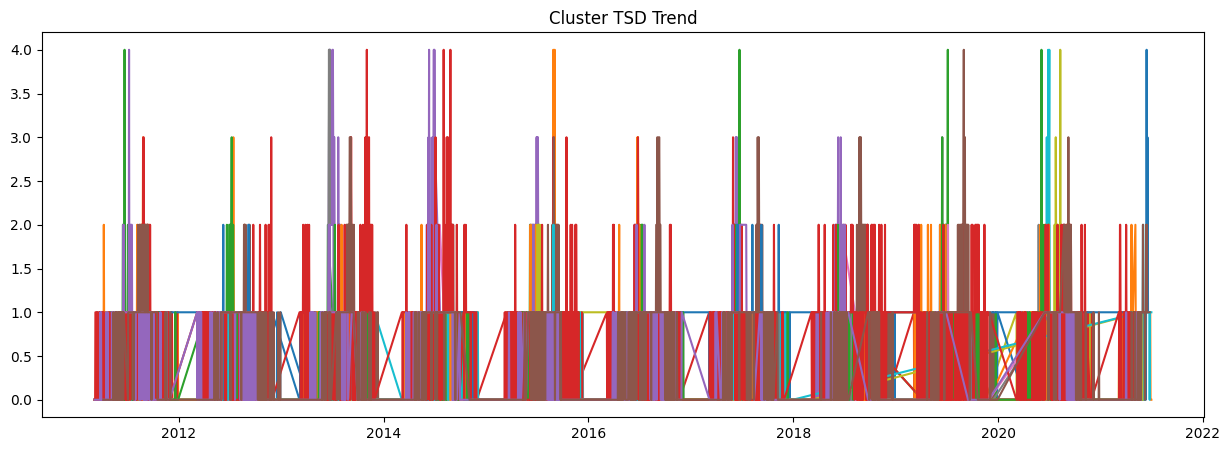

In [84]:
# Plot trends

plt.figure(figsize=(15, 5))
plt.title("Cluster TSD Trend")
for station_id, pol_var_id in dataset_df[['station_id', 'pol_var_id']].drop_duplicates().values:
    df = dataset_df[(dataset_df['station_id']==station_id) & (dataset_df['pol_var_id']==pol_var_id)]
    df.sort_index(inplace=True)
    plt.plot(df.index, df[LABEL_COL])
plt.show()

<h3>5. Create Train, Val, Test Datasets</h3>

We can use:
- data from 2011 to 2019 included as training set
- data of 2020 as validation set
- data of 2021 as test set

In [85]:
# Print period

print("Data from: {} to: {}".format(dataset_df.index.min(), dataset_df.index.max()))

Data from: 2011-03-07 00:00:00+00:00 to: 2021-07-01 00:00:00+00:00


In [86]:
# Split df into train and test sets

train_df = dataset_df[dataset_df.index < pd.to_datetime('2018-12-31 00:00:00+00:00')]
val_df = dataset_df[(dataset_df.index > pd.to_datetime('2018-12-31 00:00:00+00:00')) & 
                    (dataset_df.index < pd.to_datetime('2019-12-31 00:00:00+00:00'))]
test_df = dataset_df[(dataset_df.index > pd.to_datetime('2019-12-31 00:00:00+00:00')) & 
                     (dataset_df.index < pd.to_datetime('2021-12-31 00:00:00+00:00'))]

train_df.shape, val_df.shape, test_df.shape

((48748, 61), (4879, 61), (5036, 61))

In [87]:
# Split into feats and labels

train_X, train_y = train_df[FEATS].values, train_df[LABEL_COL]
val_X, val_y = val_df[FEATS].values, val_df[LABEL_COL]
test_X, test_y = test_df[FEATS].values, test_df[LABEL_COL]

train_X.shape, val_X.shape, test_X.shape

((48748, 58), (4879, 58), (5036, 58))

In [88]:
# Reshape X-inputs to be 3D for LSTM [samples, timesteps, features]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_X.shape, val_X.shape, test_X.shape

((48748, 1, 58), (4879, 1, 58), (5036, 1, 58))

In [89]:
# Set Y to categorical

train_y = tf.keras.utils.to_categorical(train_y.values, num_classes=K_INTERVAL, dtype='float32')
val_y = tf.keras.utils.to_categorical(val_y.values, num_classes=K_INTERVAL, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_y.values, num_classes=K_INTERVAL, dtype='float32')

<h3>6. Create & Train Model</h3>

In [90]:
# Create Model V2

input_layer = tf.keras.layers.Input(shape=(1, train_X.shape[2]))

x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=input_layer, 
                                                                value=input_layer, 
                                                                key=input_layer)
x = tf.keras.layers.Dense(units=64)(x)
x = tf.keras.layers.Flatten()(x)

x = tf.keras.layers.Dense(units=128)(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(units=128)(x)
x = tf.keras.layers.Dropout(0.4)(x)
output_layer = tf.keras.layers.Dense(activation='softmax', units=K_INTERVAL)(x)
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer) 

In [91]:
# Compile Model: V1

model.compile(loss='categorical_crossentropy', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 58)]      0           []                               
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 1, 58)       120378      ['input_2[0][0]',                
 eadAttention)                                                    'input_2[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense_4 (Dense)                (None, 1, 64)        3776        ['multi_head_attention_1[0][0]'] 
                                                                                            

In [92]:
# Train Model

history = model.fit(train_X, train_y, 
                    epochs=10,
                    validation_data=(val_X, val_y), 
                    verbose=1, 
                    callbacks=[early_stop],
                    shuffle=True)

Epoch 1/10
1524/1524 [==============================] - 7s 3ms/step - loss: 0.4633 - val_loss: 0.4136
Epoch 2/10
1524/1524 [==============================] - 5s 3ms/step - loss: 0.4334 - val_loss: 0.4270
Epoch 3/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4292 - val_loss: 0.4305
Epoch 4/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4286 - val_loss: 0.4092
Epoch 5/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4232 - val_loss: 0.4055
Epoch 6/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4220 - val_loss: 0.4075
Epoch 7/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4207 - val_loss: 0.4015
Epoch 8/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4214 - val_loss: 0.4023
Epoch 9/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.4201 - val_loss: 0.4102
Epoch 10/10
1524/1524 [==============================] - 6s 4ms/step - loss: 0.419

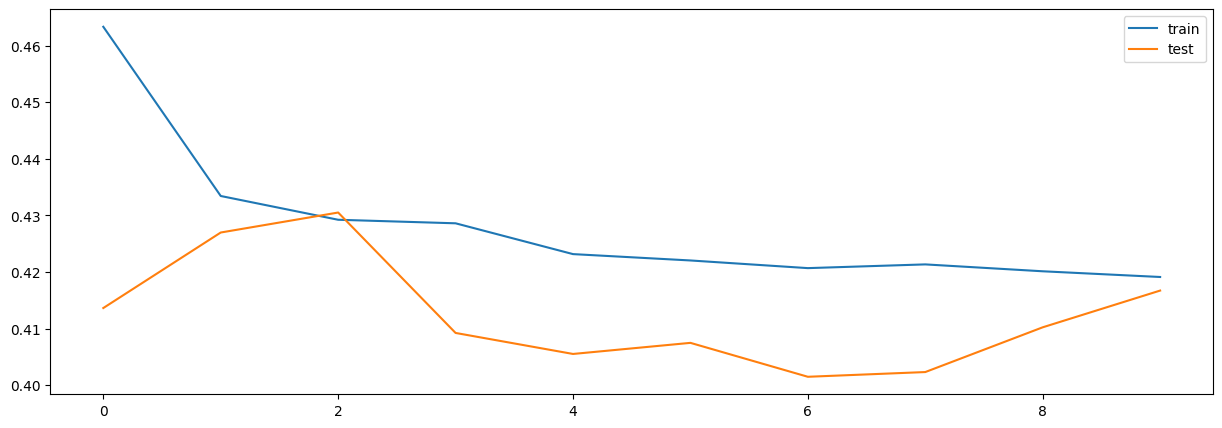

In [93]:
# Plot History

plt.figure(figsize=(15, 5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

<h3>7. Evaluate Model</h3>

<h4>7.1 Error</h4>

In [94]:
# Final Error

preds = model.predict(test_X).squeeze()    
mae = np.mean(np.abs(preds-test_y))
print("Final Mean Average Error: {}".format(mae))

158/158 [==============================] - 0s 2ms/step
Final Mean Average Error: 0.09805308282375336


<h4>7.2 Predict</h4>

In [95]:
# Predict & Assign to test_df: add values for missing days in preds

test_df['preds'] = [np.argmax(x) for x in preds]

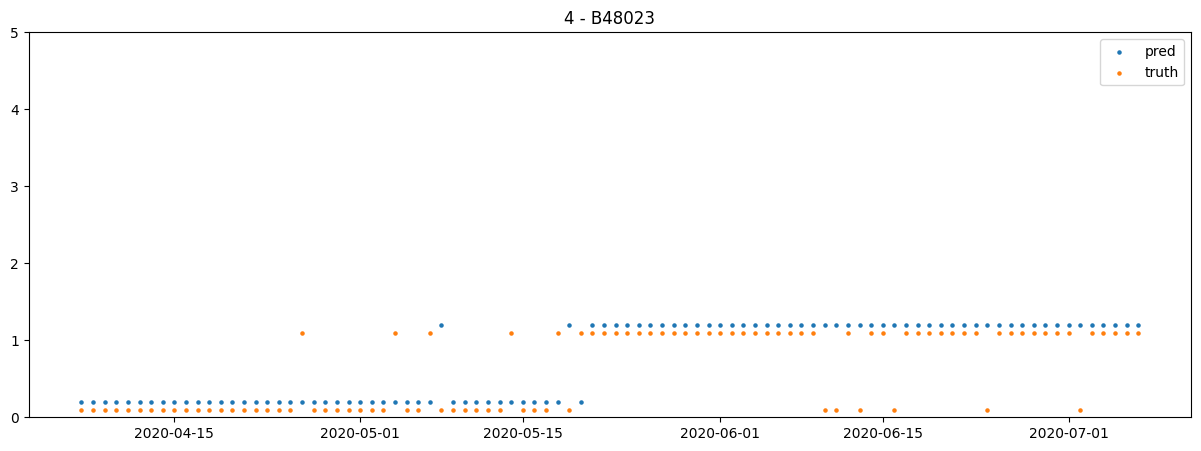

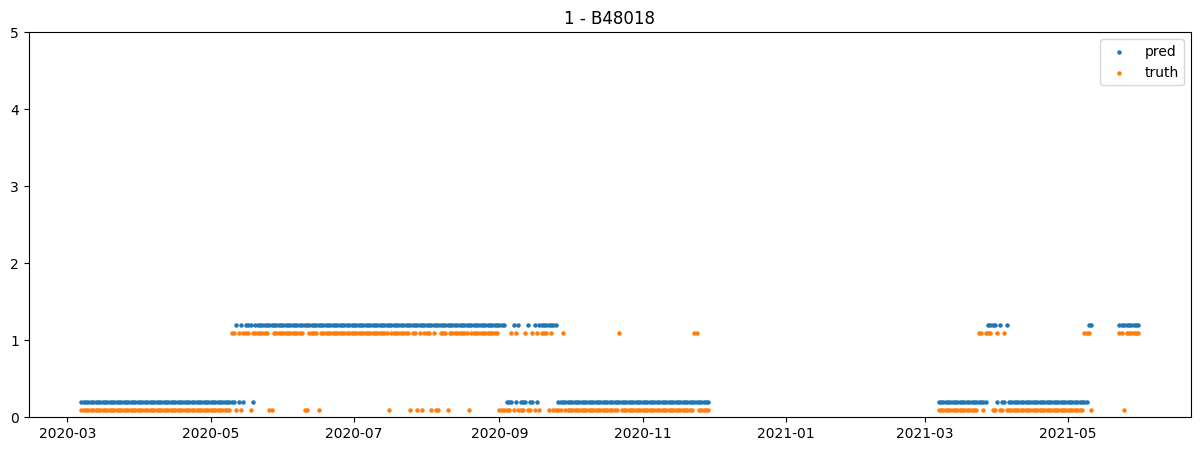

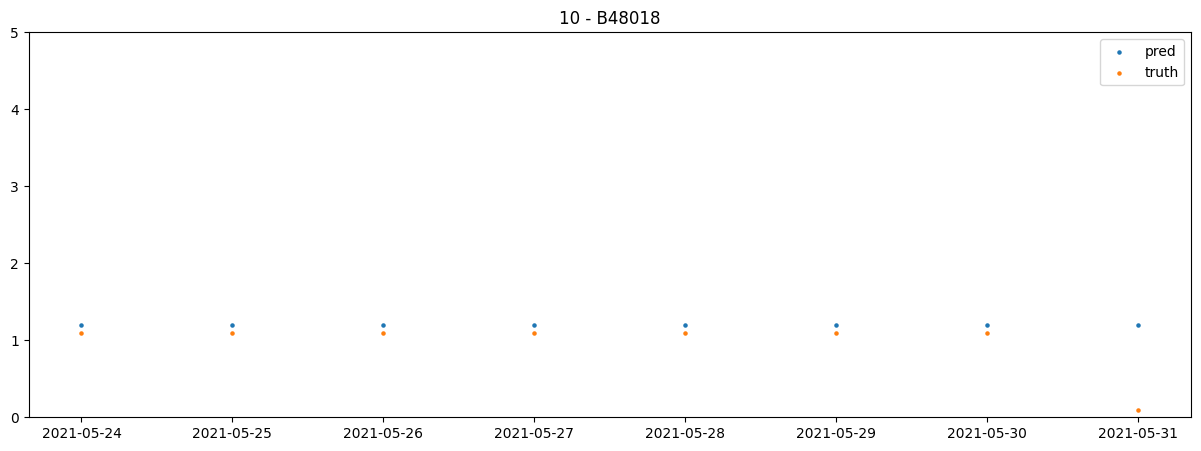

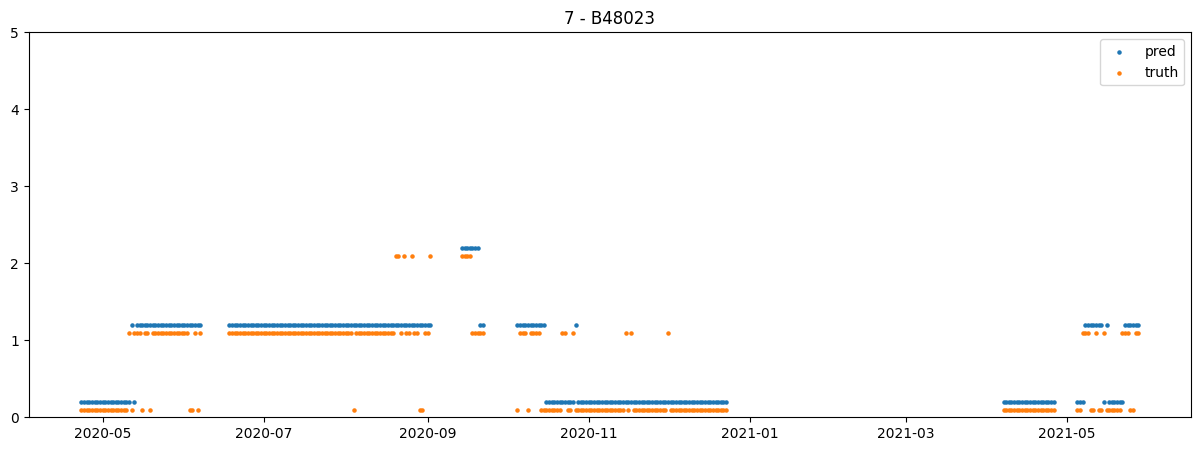

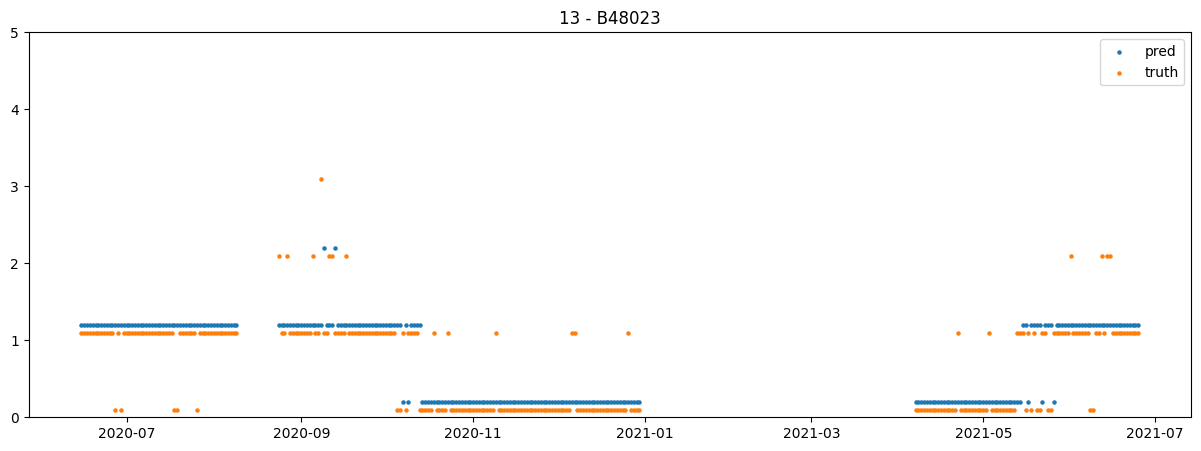

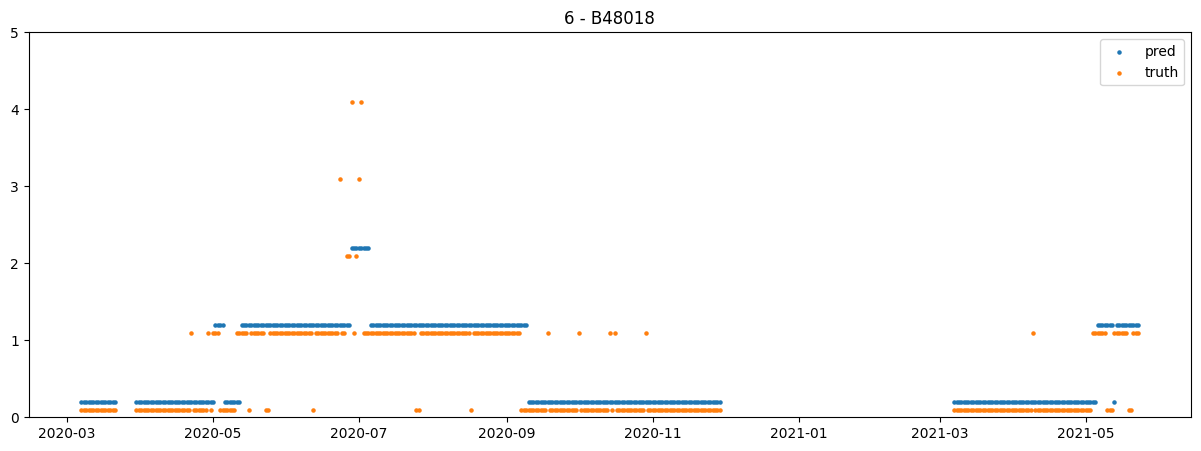

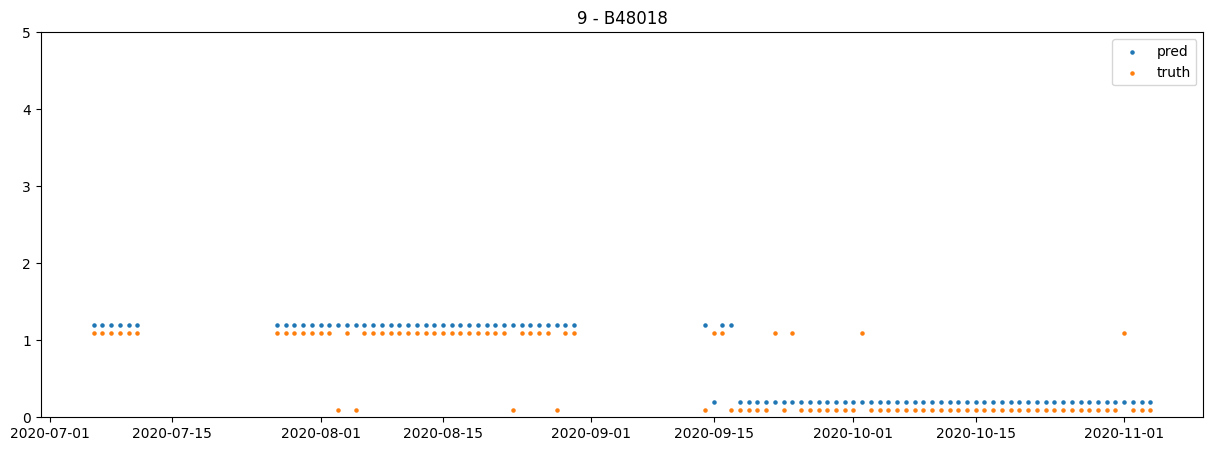

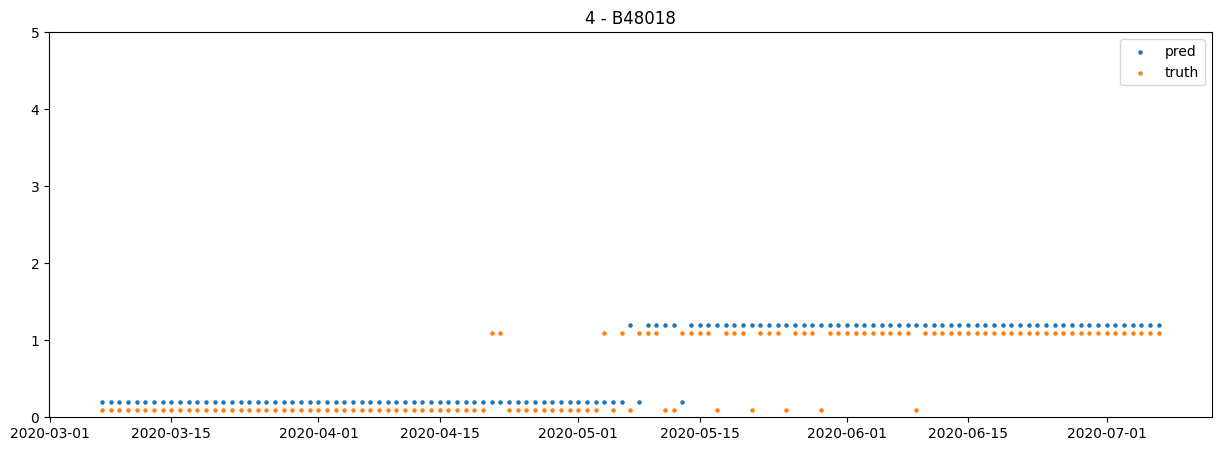

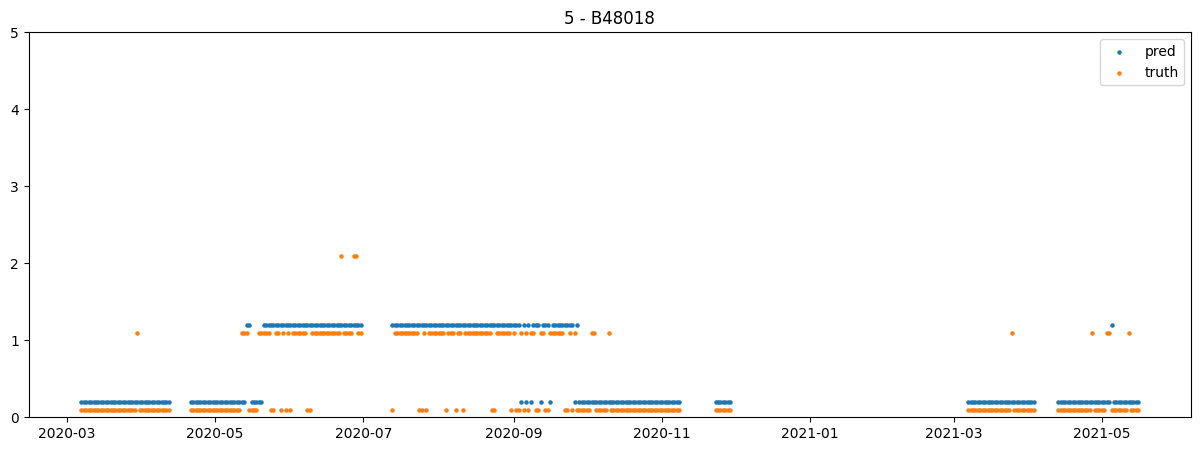

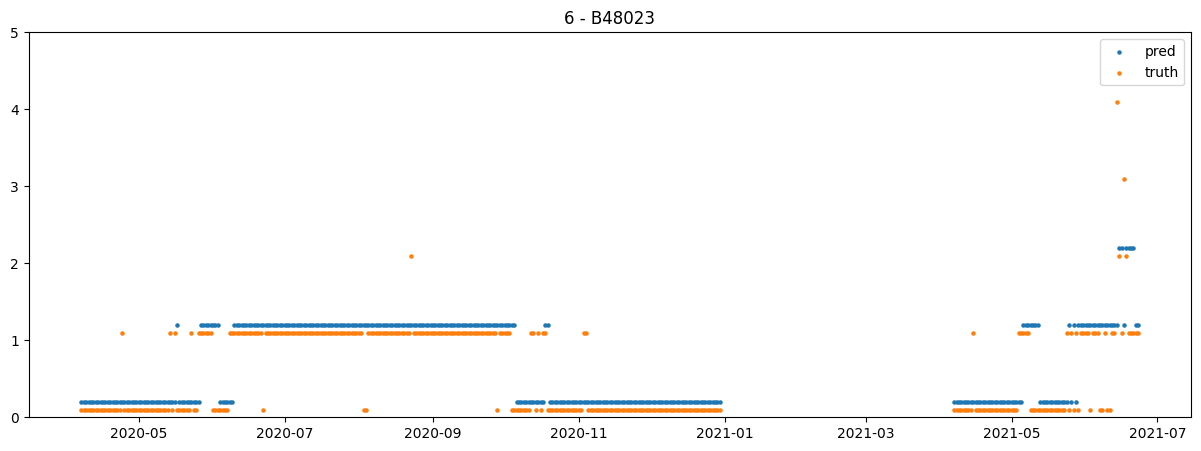

In [96]:
# Plot some station & bcode

N_SAMPLE = 10
for station_id, pol_var_id in test_df[['station_id', 'pol_var_id']].drop_duplicates().sample(N_SAMPLE).values:
    curr_test_df = test_df[(test_df['station_id']==station_id) & (test_df['pol_var_id']==pol_var_id)]
    plt.figure(figsize=(15, 5))
    plt.title("{} - {}".format(station_id, pol_var_id))
    plt.scatter(curr_test_df.index, [x+.2 for x in curr_test_df['preds']], label='pred', s=5)
    plt.scatter(curr_test_df.index, [x+.1 for x in curr_test_df[LABEL_COL]], label='truth', s=5)
    plt.legend()
    plt.ylim(0, 5)
    plt.show()